# This notebook analyzes FVS benchmark results and produces various graphics

In [59]:
#
# Configure these settings to reflect your local setup
#

DEEP1B_DATASETS= {  \
    "Deep1M": { \
        "plottitle": "1M of Deep1B", \
        "queries": { \
            10: "results/benchmarks-%s-q10.csv",\
            1000: "results/benchmarks-%s-q1000.csv" \
        } \
    }, \
    "deep2M": { \
        "plottitle": "2M of Deep1B", \
        "queries": { \
             1000: "results/benchmarks-%s-q1000.csv" \
        } \
    } \
}

NUM_APUS=1 #TODO: We should validate allocation_id

MAIN_MEMORY_SIZE = "700G"


In [60]:
#
# Imports
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
#
# Load all the CSV files into a master dataframe
#

all_dfs= []

for dset in DEEP1B_DATASETS.keys():
    for num_queries in DEEP1B_DATASETS[dset]["queries"].keys():
        df = pd.read_csv( DEEP1B_DATASETS[dset]["queries"][num_queries] % dset )
        
        df['dset_name'] = dset
        df['num_queries'] = num_queries
        all_dfs.append( df )


df_all = pd.concat( all_dfs )
print(df_all.shape)
print(df_all.columns)


(45, 14)
Index(['allocationid', 'datasetid', 'dataset_path', 'queries_path', 'bits',
       'ts_start', 'ts_train_start', 'ts_train_end', 'ts_query_start',
       'ts_query_end', 'response', 'recall', 'dset_name', 'num_queries'],
      dtype='object')


In [62]:
#
# Create throughput column
#

df_all['throughput'] = df_all.apply( \
            lambda row: row['num_queries']/row['response'], axis=1 )
    
print(df_all[["dset_name","bits","response","recall", "throughput"]])

   dset_name  bits  response  recall   throughput
0     Deep1M   768  0.020478  1.0000   488.334710
1     Deep1M   768  0.017423  1.0000   573.953474
2     Deep1M   768  0.018164  1.0000   550.533013
3     Deep1M   512  0.021775  1.0000   459.249379
4     Deep1M   512  0.020864  1.0000   479.303071
5     Deep1M   512  0.020356  1.0000   491.248651
6     Deep1M   256  0.009880  1.0000  1012.132634
7     Deep1M   256  0.010556  1.0000   947.327907
8     Deep1M   256  0.011289  1.0000   885.820644
9     Deep1M   128  0.010454  0.9800   956.616578
10    Deep1M   128  0.010239  0.9800   976.634983
11    Deep1M   128  0.011786  0.9800   848.473780
12    Deep1M    64  0.007231  0.9700  1383.016827
13    Deep1M    64  0.007764  0.9700  1288.075512
14    Deep1M    64  0.007544  0.9700  1325.524754
0     Deep1M   768  2.915360  0.9997   343.010825
1     Deep1M   768  2.940215  0.9997   340.111132
2     Deep1M   768  2.875883  0.9997   347.719296
3     Deep1M   512  0.887977  0.9997  1126.155282


In [63]:
# 
# Grouping rows by (num_queries,bits) and then average 'recall' and 'throughput'
# 

df_plot = \
    df_all[["dset_name", "num_queries","bits","recall","throughput"]].\
        groupby(["dset_name",'num_queries', 'bits'], as_index=False).mean()
print(df_plot)

   dset_name  num_queries  bits  recall   throughput
0     Deep1M           10    64  0.9700  1332.205698
1     Deep1M           10   128  0.9800   927.241780
2     Deep1M           10   256  1.0000   948.427062
3     Deep1M           10   512  1.0000   476.600367
4     Deep1M           10   768  1.0000   537.607066
5     Deep1M         1000    64  0.9455  2095.429609
6     Deep1M         1000   128  0.9899  1641.694126
7     Deep1M         1000   256  0.9994  1606.490680
8     Deep1M         1000   512  0.9997  1123.356144
9     Deep1M         1000   768  0.9997   343.613751
10    deep2M         1000    64  0.9215  1551.033797
11    deep2M         1000   128  0.9872  1474.170855
12    deep2M         1000   256  0.9989   129.805398
13    deep2M         1000   512  1.0000   121.694335
14    deep2M         1000   768  1.0000   118.895884


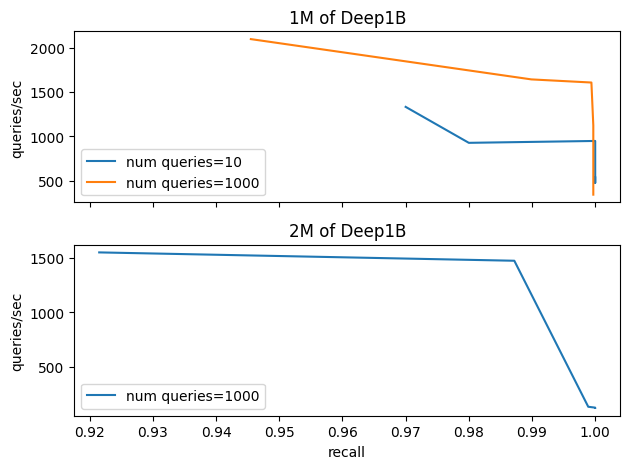

In [67]:
# 
# Plot the data
#
num_plots = len( DEEP1B_DATASETS.keys() )

fig, axs = plt.subplots(num_plots, sharex=True)

for d, dset in enumerate(DEEP1B_DATASETS.keys()):
    for q, num_queries in enumerate(DEEP1B_DATASETS[dset]["queries"]):
        recalls = df_plot.loc[ \
                (df_plot['dset_name']==dset) & \
                (df_plot['num_queries']==num_queries)\
                ]["recall"]
        throughputs = df_plot.loc[ \
                (df_plot['dset_name']==dset) & \
                (df_plot['num_queries']==num_queries)\
                ]["throughput"]
        axs[d].plot( recalls, throughputs, label="num queries=%d" % num_queries )
        axs[d].set_title( DEEP1B_DATASETS[dset]["plottitle"] )
        axs[d].set_ylabel("queries/sec")
        if d==len(DEEP1B_DATASETS[dset].keys())-1:
            axs[d].set_xlabel("recall")
        axs[d].legend()
        
plt.tight_layout()
plt.savefig("results/gemini_fvs_deep1B.png")